In [1]:
import numpy as np
import trimesh
import scipy

In [96]:
# create test and train set 
# save it as txt files
import glob
import random
def get_random_train_list():
    files = glob.glob('data/xyz/*.xyz')
    train = random.sample(files, 120)
    train_set = set(train)
    train_list = []
    test_list = []
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if file in train_set:
            train_list.append(name)
        else:
            test_list.append(name)

    return train_list, test_list
def write_list_to_file(filename,my_list):
    with open(filename, 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)
train_list, test_list = get_random_train_list()
write_list_to_file('data/trainingset.txt', train_list)
write_list_to_file('data/testset.txt', test_list)

In [3]:
from random import sample
import glob
import trimesh
def save_xyz(pts, file_name):
    # print(pts)
    s = trimesh.util.array_to_string(pts)
    with open(file_name, 'w') as f:
        f.write("%s\n" % s)
def sample_k(matrix,k):
    # matrix = matrix.toarray()
    result = []
    for i,row in enumerate(matrix):
        row = list(row)
        if len(row) >= k:
            k_nearest = sample(row,k)
        else:
            while len(row) < k:
                row.append(0.0)
            k_nearest = row
        result.append(k_nearest)
    return result
def save_vertices():
    files = glob.glob('data/new_data/smooth_mesh/*.obj')
    for file in files:
        # print(file)
        mesh = trimesh.load_mesh(file)
        vertices = mesh.vertices
        dest_name = 'data/new_data/smooth_xyz/' +file.split('/')[-1].split('.')[0] +'.xyz'
        save_xyz(vertices, dest_name)
        
        
def create_target():
    files = glob.glob('data/noisy/*.obj')
    for file in files:
        print(file)
        mesh = trimesh.load_mesh(file)
        result = knn_cotangent_laplacian(mesh, 6)
    
        dest_name = 'data/laplacian/' +file.split('/')[-1].split('.')[0] +'.laplacian'
        save_xyz(result, dest_name)
        break

save_vertices()


In [2]:
from scipy.sparse import coo_matrix, eye
from scipy.spatial import distance
def get_cotangent_weight(i,neighbor,neighbors,norms, KNN):
    def get_k_h(i,j):
        list1, list2 = neighbors[i], neighbors[j]
        #if there is morethan 2 intersection choose the first 2 points
        intersection = list(set(list1).intersection(list2))
        try:
            k,h = intersection
        except:
            k,h = intersection[:2]
            # print(intersection)
            # print(i,j)
            # print('k,h', )

        return k,h
    def get_distance(i,j,k,h):
        j_idx = neighbors[i].index(j)
        lij = norms[i][j_idx]

        k_idx = neighbors[j].index(k)
        ljk = norms[j][k_idx]

        i_idx = neighbors[k].index(i)
        lki = norms[k][i_idx]

        h_idx = neighbors[j].index(h)
        ljh = norms[j][h_idx]

        i_idx = neighbors[h].index(i)
        lhi = norms[h][i_idx]

        return lij, ljk, lki, ljh, lhi 

    result = []
    for j in KNN:
        #if j in neighbor find Cotangent weight else assign 0
        wij = 0
        if j in neighbor:
            
            k,h  = get_k_h(i,j)
            lij, ljk, lki, ljh, lhi = get_distance(i,j,k,h)

            s_ijk = (lij + ljk + lki)/2
            A_ijk = 8 *  np.sqrt(s_ijk * ( s_ijk - lij) * ( s_ijk- ljk) * ( s_ijk - lki))

            s_ijh = (lij + ljh + lhi)/2
            A_ijh = 8 *  np.sqrt(s_ijh * ( s_ijh - lij) * ( s_ijh- ljh) * ( s_ijh - lhi))

            
            wij = ((-lij**2 + ljk ** 2 + lki**2)/  A_ijk)  + ((-lij**2 + ljh ** 2 + lhi**2)/  A_ijh)
        
       
        result.append(wij)
        
    return result

def knn_cotangent_laplacian(mesh, k):
    neighbors = mesh.vertex_neighbors
    
    vertices = mesh.vertices.view(np.ndarray)

    ones = np.ones(3)
    norms = [np.sqrt(np.dot((vertices[i] - vertices[n]) ** 2, ones))
                for i, n in enumerate(neighbors)]
    D = distance.squareform(distance.pdist(vertices))
    closest = np.argsort(D, axis=1)
    closest = closest[:, 1:k+1]



    # norms = [i / i.sum() for i in norms]
    data = []

    for i, KNN in enumerate(closest):
        neighbor = neighbors[i]
        weight = get_cotangent_weight(i,neighbor, neighbors,norms, KNN)
        data.append(weight)
        # create the sparse matrix
    
    col = np.concatenate(closest)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(closest)])
    
   

    data = np.concatenate([i / np.array(i).sum() if np.array(i).sum()>0 else i for i in data])
    
    
    matrix = coo_matrix((data, (row, col)),
                        shape=[len(vertices)] * 2)
    return matrix


In [16]:

from scipy.sparse import coo_matrix, eye
from scipy.spatial import distance
from scipy import sparse
def get_pred_matrix(mesh, k, fname):
    neighbors = mesh.vertex_neighbors
    
    vertices = mesh.vertices.view(np.ndarray)

    ones = np.ones(3)
    norms = [np.sqrt(np.dot((vertices[i] - vertices[n]) ** 2, ones))
                for i, n in enumerate(neighbors)]
    D = distance.squareform(distance.pdist(vertices))
    closest = np.argsort(D, axis=1)
    closest = closest[:, 1:k+1]



    # norms = [i / i.sum() for i in norms]
    data = np.genfromtxt(fname, delimiter=' ')
    

    # for i, KNN in enumerate(closest):
    #     neighbor = neighbors[i]
    #     weight = text_array()
    #     data.append(weight)
    #     # create the sparse matrix
    
    col = np.concatenate(closest)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(closest)])
    
   

    data = np.concatenate([i / np.array(i).sum() if np.array(i).sum()>0 else i for i in data])
    
    
    matrix = coo_matrix((data, (row, col)),
                        shape=[len(vertices)] * 2)
    return matrix
def make_smooth(mesh, matrix= None):
    if matrix != None:
        matrix = matrix
    else:
        # print("Matrix = None")
        matrix = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= True)
        
    smoothed_mesh = trimesh.smoothing.filter_taubin(mesh, lamb=0.4, nu=0.5, iterations=10, laplacian_operator=matrix)
                    
    return smoothed_mesh
def smooth_bunch():
    with open('data/new_data/testset_combined.txt') as f:
        for line in f:
            line = line.strip('\n') + '.obj'
            mesh_path = 'data/new_data/noisy_mesh/'+line
            mesh = trimesh.load_mesh(mesh_path)
            fname = 'results/denoise_50-300_meshes/' + line.split('.')[0] +'.laplacian'
            matrix = get_pred_matrix(mesh, 6, fname)
            #save the matrix
            sparse.save_npz("output/denoise_50-300_meshes_matrix/"+line.split('.')[0] +'.npz', matrix)
            smoothed =  make_smooth(mesh,matrix)
            outpath = 'output/denoise_50-300_meshes/'+line
            output = smoothed.export(outpath)
            print(line)
            # break

'''
smooth_path = 'data/smooth/meshes_march2_mesh_0070.obj'
mesh_path = 'data/noisy/meshes_march2_mesh_0070.obj'
outpath = 'output/meshes_march2_mesh_0070_pred.obj'


fname = 'results/laplacian_denoise_model/meshes_march2_mesh_0070.normals'
k = 6
mesh = trimesh.load_mesh(mesh_path)
matrix = get_pred_matrix(mesh, 6, fname)


# matrix_cotangent = knn_cotangent_laplacian(mesh,6)
smoothed =  make_smooth(mesh,matrix)
output = smoothed.export(outpath)
smoothed_mesh = trimesh.load_mesh(outpath)
smoothed_mesh.show()


# print('=============================\n', matrix)
'''
smooth_bunch()

meshes_march1_mesh_0210.obj
meshes_bouncing_mesh_0000.obj
meshes_squat1_mesh_0000.obj
meshes_squat2_mesh_0040.obj
meshes_handstand_mesh_0130.obj
meshes_squat1_mesh_0130.obj
meshes_crane_mesh_0120.obj
meshes_crane_mesh_0090.obj
meshes_squat2_mesh_0240.obj
meshes_march2_mesh_0060.obj
meshes_handstand_mesh_0110.obj
meshes_squat2_mesh_0140.obj
trim-star_n1.obj
star_n2.obj
fandisk_n2.obj
girl-scanned_n1.obj
chinese-lion_n2.obj
cad_n3.obj


In [14]:
from scipy import sparse
fname = 'results/denoise/meshes_march1_mesh_0210.laplacian'
# fname = 'data/laplacian/meshes_squat2_mesh_0230.laplacian'
k = 6
mesh = trimesh.load_mesh('data/new_data/noisy_mesh/meshes_march1_mesh_0210.obj')
# matrix = get_pred_matrix(mesh, 6, fname)
# sparse.save_npz("output/denoise_50-300_meshes_matrix/meshes_march1_mesh_0210.npz", matrix)
matrix = sparse.load_npz("output/denoise_50-300_meshes_matrix/meshes_march1_mesh_0210.npz")
# type(your_matrix_back)
# # mesh = trimesh.load_mesh(mesh_path)
# # matrix_cotangent = knn_cotangent_laplacian(mesh,8)
smoothed =  make_smooth(mesh,matrix)
# # output = smoothed.export(outpath)
# # smoothed_mesh = trimesh.load_mesh(outpath)
# smoothed.show()
# fname = 'data/laplacian/meshes_bouncing_mesh_0130.laplacian'
# k = 6
# mesh = trimesh.load_mesh(mesh_path)
# matrix = get_pred_matrix(mesh, k, fname)


# # matrix_cotangent = knn_cotangent_laplacian(mesh,6)
# smoothed =  make_smooth(mesh,matrix)
smoothed.show()

In [10]:
mesh = trimesh.load_mesh('data/new_data/noisy_mesh/girl-scanned_n1.obj')
mesh.show()

In [25]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import glob 
# from chamferdist import ChamferDistance
chamfer_loss = 0
def calculate_loss(mesh1, mesh2):
    # loss = ChamferDistance()
    mse_loss = torch.nn.MSELoss()
    mesh1 = trimesh.load_mesh(mesh1)
    mesh2 = trimesh.load_mesh(mesh2)
    v1, v2 = mesh1.vertices.view(np.ndarray),mesh2.vertices.view(np.ndarray)
    v1, v2  = torch.tensor(v1).float().unsqueeze(0), torch.tensor(v2).float().unsqueeze(0)
    
    # chamfer_loss = loss(v1, v2)
    mse_loss = mse_loss(v1, v2)
    # print('===================================')
    # print('loss(smooth_gt,noisy_gt)')
    # print('ChamferDistance: ', chamfer_loss)
    # print('MSE: ', mse_loss)
    # print('===================================')
    return chamfer_loss, mse_loss

def loss_bunch():
    files = glob.glob('output/knn_cotangent/*.obj')
    chamfer_total, mse_total = 0, 0
    for file in files:
        mesh1 = 'data/smooth/'+file.split('/')[-1]
        mesh2 = file
        chamfer, mse = calculate_loss(mesh1, mesh2)
        chamfer_total += chamfer
        mse_total += mse
    chamfer_total, mse_total = chamfer_total/len(files), mse_total/len(files)
    print('ChamferDistance: ', chamfer_total)
    print('MSE: ', mse_total)

loss_bunch()
# mesh1 = 'data/smooth/meshes_bouncing_mesh_0020.obj'
# mesh2 = 'data/noisy/meshes_bouncing_mesh_0020.obj'

# chamfer, mse = calculate_loss(outpath, mesh1)
# print('===================================')
# print('loss(smooth_gt,noisy_gt)')
# print('ChamferDistance: ', chamfer)
# print('MSE: ', mse)
# print('===================================')
'''
===================================
between Equal weight False & True: loss(smooth_gt,smooth_true)
ChamferDistance:  tensor(0.0306)
MSE:  tensor(0.1742)

===================================

loss(smooth_gt,smooth_pred_true)
ChamferDistance:  tensor(0.0948)
MSE:  tensor(0.1706)
===================================

===================================
loss(smooth_gt,smooth_pred_false)
ChamferDistance:  tensor(0.0399)
MSE:  tensor(0.1719)
===================================

===================================
loss(smooth_gt,noisy_gt)
ChamferDistance:  tensor(0.0296)
MSE:  tensor(0.1707)
===================================

[laplacian_denoise_model 499: 1872/1874] test loss: 0.013977
[laplacian_denoise_model 499: 1873/1874] train loss: 0.014075

'''

ChamferDistance:  0.0
MSE:  tensor(0.1875)


'\n===================================\nbetween Equal weight False & True: loss(smooth_gt,smooth_true)\nChamferDistance:  tensor(0.0306)\nMSE:  tensor(0.1742)\n\n===================================\n\nloss(smooth_gt,smooth_pred_true)\nChamferDistance:  tensor(0.0948)\nMSE:  tensor(0.1706)\n===================================\n\n===================================\nloss(smooth_gt,smooth_pred_false)\nChamferDistance:  tensor(0.0399)\nMSE:  tensor(0.1719)\n===================================\n\n===================================\nloss(smooth_gt,noisy_gt)\nChamferDistance:  tensor(0.0296)\nMSE:  tensor(0.1707)\n===================================\n\n[laplacian_denoise_model 499: 1872/1874] test loss: 0.013977\n[laplacian_denoise_model 499: 1873/1874] train loss: 0.014075\n\n'

In [5]:
from scipy.sparse import coo_matrix, eye
from scipy.spatial import distance
def get_pred_matrix(mesh, k, fname):
    neighbors = mesh.vertex_neighbors
    
    vertices = mesh.vertices.view(np.ndarray)

    ones = np.ones(3)
    norms = [np.sqrt(np.dot((vertices[i] - vertices[n]) ** 2, ones))
                for i, n in enumerate(neighbors)]
    D = distance.squareform(distance.pdist(vertices))
    closest = np.argsort(D, axis=1)
    closest = closest[:, 1:k+1]



    # norms = [i / i.sum() for i in norms]
    data = np.genfromtxt(fname, delimiter=' ')
    

    # for i, KNN in enumerate(closest):
    #     neighbor = neighbors[i]
    #     weight = text_array()
    #     data.append(weight)
    #     # create the sparse matrix
    
    col = np.concatenate(closest)
    row = np.concatenate([[i] * len(n)
                          for i, n in enumerate(closest)])
    
   

    data = np.concatenate([i / np.array(i).sum() if np.array(i).sum()>0 else i for i in data])
    
    
    matrix = coo_matrix((data, (row, col)),
                        shape=[len(vertices)] * 2)
    return matrix
# fname = 'results/laplacian_denoise_model/meshes_march2_mesh_0070.normals'
# k = 6
# mesh = trimesh.load_mesh('data/noisy/meshes_march2_mesh_0070.obj')
# matrix = get_pred_matrix(mesh, 6, fname)

In [2]:
from scipy.sparse.linalg import eigs
import numpy as np
id = np.eye(13)
eig =  eigs(id)
eig

(array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 array([[ 0.29528113+0.j,  0.37421118+0.j,  0.24563657+0.j,
         -0.06948618+0.j, -0.06831006+0.j, -0.40342167+0.j],
        [-0.17621668+0.j,  0.11767367+0.j, -0.11894216+0.j,
          0.11423751+0.j,  0.01744547+0.j, -0.1711844 +0.j],
        [ 0.14772714+0.j, -0.25944351+0.j, -0.04563225+0.j,
         -0.0510926 +0.j, -0.63331919+0.j,  0.20413052+0.j],
        [ 0.37013186+0.j,  0.00985048+0.j, -0.05899912+0.j,
          0.4797019 +0.j,  0.28722912+0.j, -0.31443573+0.j],
        [-0.06242452+0.j,  0.12531843+0.j,  0.15862538+0.j,
         -0.0420561 +0.j, -0.02896331+0.j, -0.03601115+0.j],
        [-0.65938899+0.j,  0.14822092+0.j,  0.06725746+0.j,
         -0.15006064+0.j, -0.07995334+0.j,  0.00339715+0.j],
        [-0.01168042+0.j, -0.2876552 +0.j, -0.07018555+0.j,
         -0.06303173+0.j,  0.58904692+0.j,  0.27521461+0.j],
        [-0.48576324+0.j,  0.20897042+0.j, -0.19714114+0.j,
          0.21694794+0.j,  0.113240

In [17]:
#eigenvalue
from scipy.sparse.linalg import eigs
import numpy as np
import polyscope as ps
import trimesh
import os
from scipy import sparse
def eigen_decomposition(mesh,lapl_path,out_path):
    laplacian = get_pred_matrix(mesh, k=6, fname=lapl_path)
    # laplacian = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= False)
    n_eig = 10
    vals, vecs = eigs(laplacian, k=n_eig)

    ps.init()
    mesh = make_smooth(mesh,matrix= laplacian)
    vertices = np.array(mesh.vertices)
    faces =np.array( mesh.faces)
    # faces = np.random.randint(0, 100, size=(250,3)) # (F,3) array of indices 
    #                                                 # for triangular faces

    # # visualize!

    ps_mesh = ps.register_surface_mesh("my mesh", vertices, faces)
    ps.set_ground_plane_mode = "none"
    ps.set_ground_plane_height_factor(0)
    # set the camera pose explicitly
    # ps.look_at((0., 1.2, 2.), (-0.7, 1., 0.))

    # (alternately, use numpy vectors)
    # ps.look_at(np.array((0., 0., 5.)), np.array((1., 1., 1.)))
    # ps.set_shadow_darkness = 0
    for i in range(n_eig):
        # i = 4
        ps_mesh.add_scalar_quantity("eigenvector_"+str(i), vecs[:,i], enabled=True)
        ps.screenshot(out_path+'/'+str(i)+".png", True)
        
    ps.show()
    return ps
def bunch_eigen():
    with open('data/testset.txt') as f:
        for line in f:

            name = line.strip('\n') 
            out_path = 'output/eigen_decomposition/gt_noisy/'+name
            if not os.path.exists(out_path):
                os.makedirs(out_path)
            mesh_path = 'data/noisy/'+name + '.obj'
            mesh = trimesh.load_mesh(mesh_path)
    
            lapl_path = 'data/laplacian/' + name+'.laplacian'
            eigen_decomposition(mesh,lapl_path, out_path)
        
            print(name)
            break
            
def eigen_val(laplacian):
    # laplacian = get_pred_matrix(mesh, k=6, fname=lapl_path)
    # laplacian = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= False)
    n_eig = 10
    vals, vecs = eigs(laplacian, k=n_eig)
    return vals, vecs

mesh_path = 'output/denoise_50-300_meshes/meshes_march1_mesh_0210.obj'
mesh = trimesh.load_mesh(mesh_path)
laplacian = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= False)
vals_neq, vecs_neq = eigen_val(laplacian)

laplacian = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= True)
vals_eq, vecs_eq = eigen_val(laplacian)

lapl_matrix = sparse.load_npz("output/denoise_50-300_meshes_matrix/meshes_march1_mesh_0210.npz")
vals_pred, vecs_pred = eigen_val(lapl_matrix)
# lapl_path = 'data/laplacian//meshes_squat1_mesh_0050.laplacian'

# ps = eigen_decomposition(mesh,lapl_path, '')
# ps.show()
# bunch_eigen()

TypeError: quiver() takes 2-5 positional arguments but 12 were given

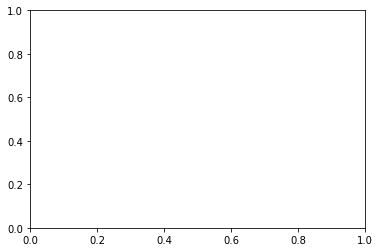

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import linalg as LA

# Assume that I loaded 'N' no of 2d points from a file and used
# np.cov() to find the below covariance matrix

# This is my covariance matrix obtained from 2 x N points
# cov_mat = [[3407.3108669,  1473.06388943],
#            [1473.06388943, 1169.53151003]]

# eigen_values, eigen_vectors = LA.eig(cov_mat)

origin = [0, 0]

# eig_vec1 = eigen_vectors[:,0]
# eig_vec2 = eigen_vectors[:,1]

# print(eig_vec1)
# print(eig_vec2)


# This line below plots the 2d points
#plt.scatter(np_array[:,0], np_array[:,1])

plt.quiver(*origin, *vecs_eq[0], color=['r'], scale=21)
plt.quiver(*origin, *vecs_pred[0], color=['b'], scale=21)
plt.show()

In [18]:
mesh_path = 'data/internet_mesh/chinese-lion_n2.obj'

lapl_path = 'results/laplacian_denoise_model/chinese-lion_n2.laplacian'
mesh = trimesh.load_mesh(mesh_path)
# laplacian = trimesh.smoothing.laplacian_calculation(mesh, equal_weight= False)
# laplacian = knn_cotangent_laplacian(mesh, 6)
laplacian = get_pred_matrix(mesh, k=6, fname=lapl_path)
mesh = make_smooth(mesh,matrix= laplacian)
mesh.show()


In [5]:
from scipy.sparse.linalg import eigs
import numpy as np
import polyscope as ps
import trimesh
import os

mesh_path = 'data/internet_mesh/girl-scanned_n1.obj'
mesh = trimesh.load_mesh(mesh_path)

ps.init()
vertices = np.array(mesh.vertices)
faces =np.array( mesh.faces)

ps_mesh = ps.register_surface_mesh("my mesh", vertices, faces)
ps.show()

In [8]:
outpath= "output/chinese-lion_n2_50-300.obj"
output = smoothed.export(outpath)